# Calculating and Plotting [Isochrones](http://en.wikipedia.org/wiki/Isochrone_map) for London Bike Hire Stations

#### (Other Python geo notebooks are available at [https://github.com/urschrei/Geopython](https://github.com/urschrei/Geopython))

In [2]:
import requests
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.colors as colors
from matplotlib.mlab import griddata
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import griddata as gd
from shapely.geometry import mapping, Point, Polygon, LineString, MultiPolygon, MultiPoint, box
from shapely.ops import unary_union
from descartes import PolygonPatch
import math
import fiona
from itertools import chain, permutations, combinations
import json
from lxml import etree
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 12)
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['axes.grid'] = False   # display grid or not

### Only execute the following cell if you have LaTeX Installed

In [3]:
from matplotlib import rc
rc('font', **{'family':'sans-serif',
    'sans-serif':['Helvetica'],
    'monospace': ['Inconsolata'],
    'serif': ['Helvetica']})
rc('text', **{'usetex': True})
rc('text', **{'latex.preamble': '\usepackage{sfmath}'})

## Map Setup

In [4]:
shp = fiona.open('data/london_wards.shp')
crs_data = shp.crs
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

(649,
 5,
 [-0.5103750689005356, 51.28676016315085, 0.0, 0.0],
 [0.3340155643740321, 51.691874116909894, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x10ae1b050>)

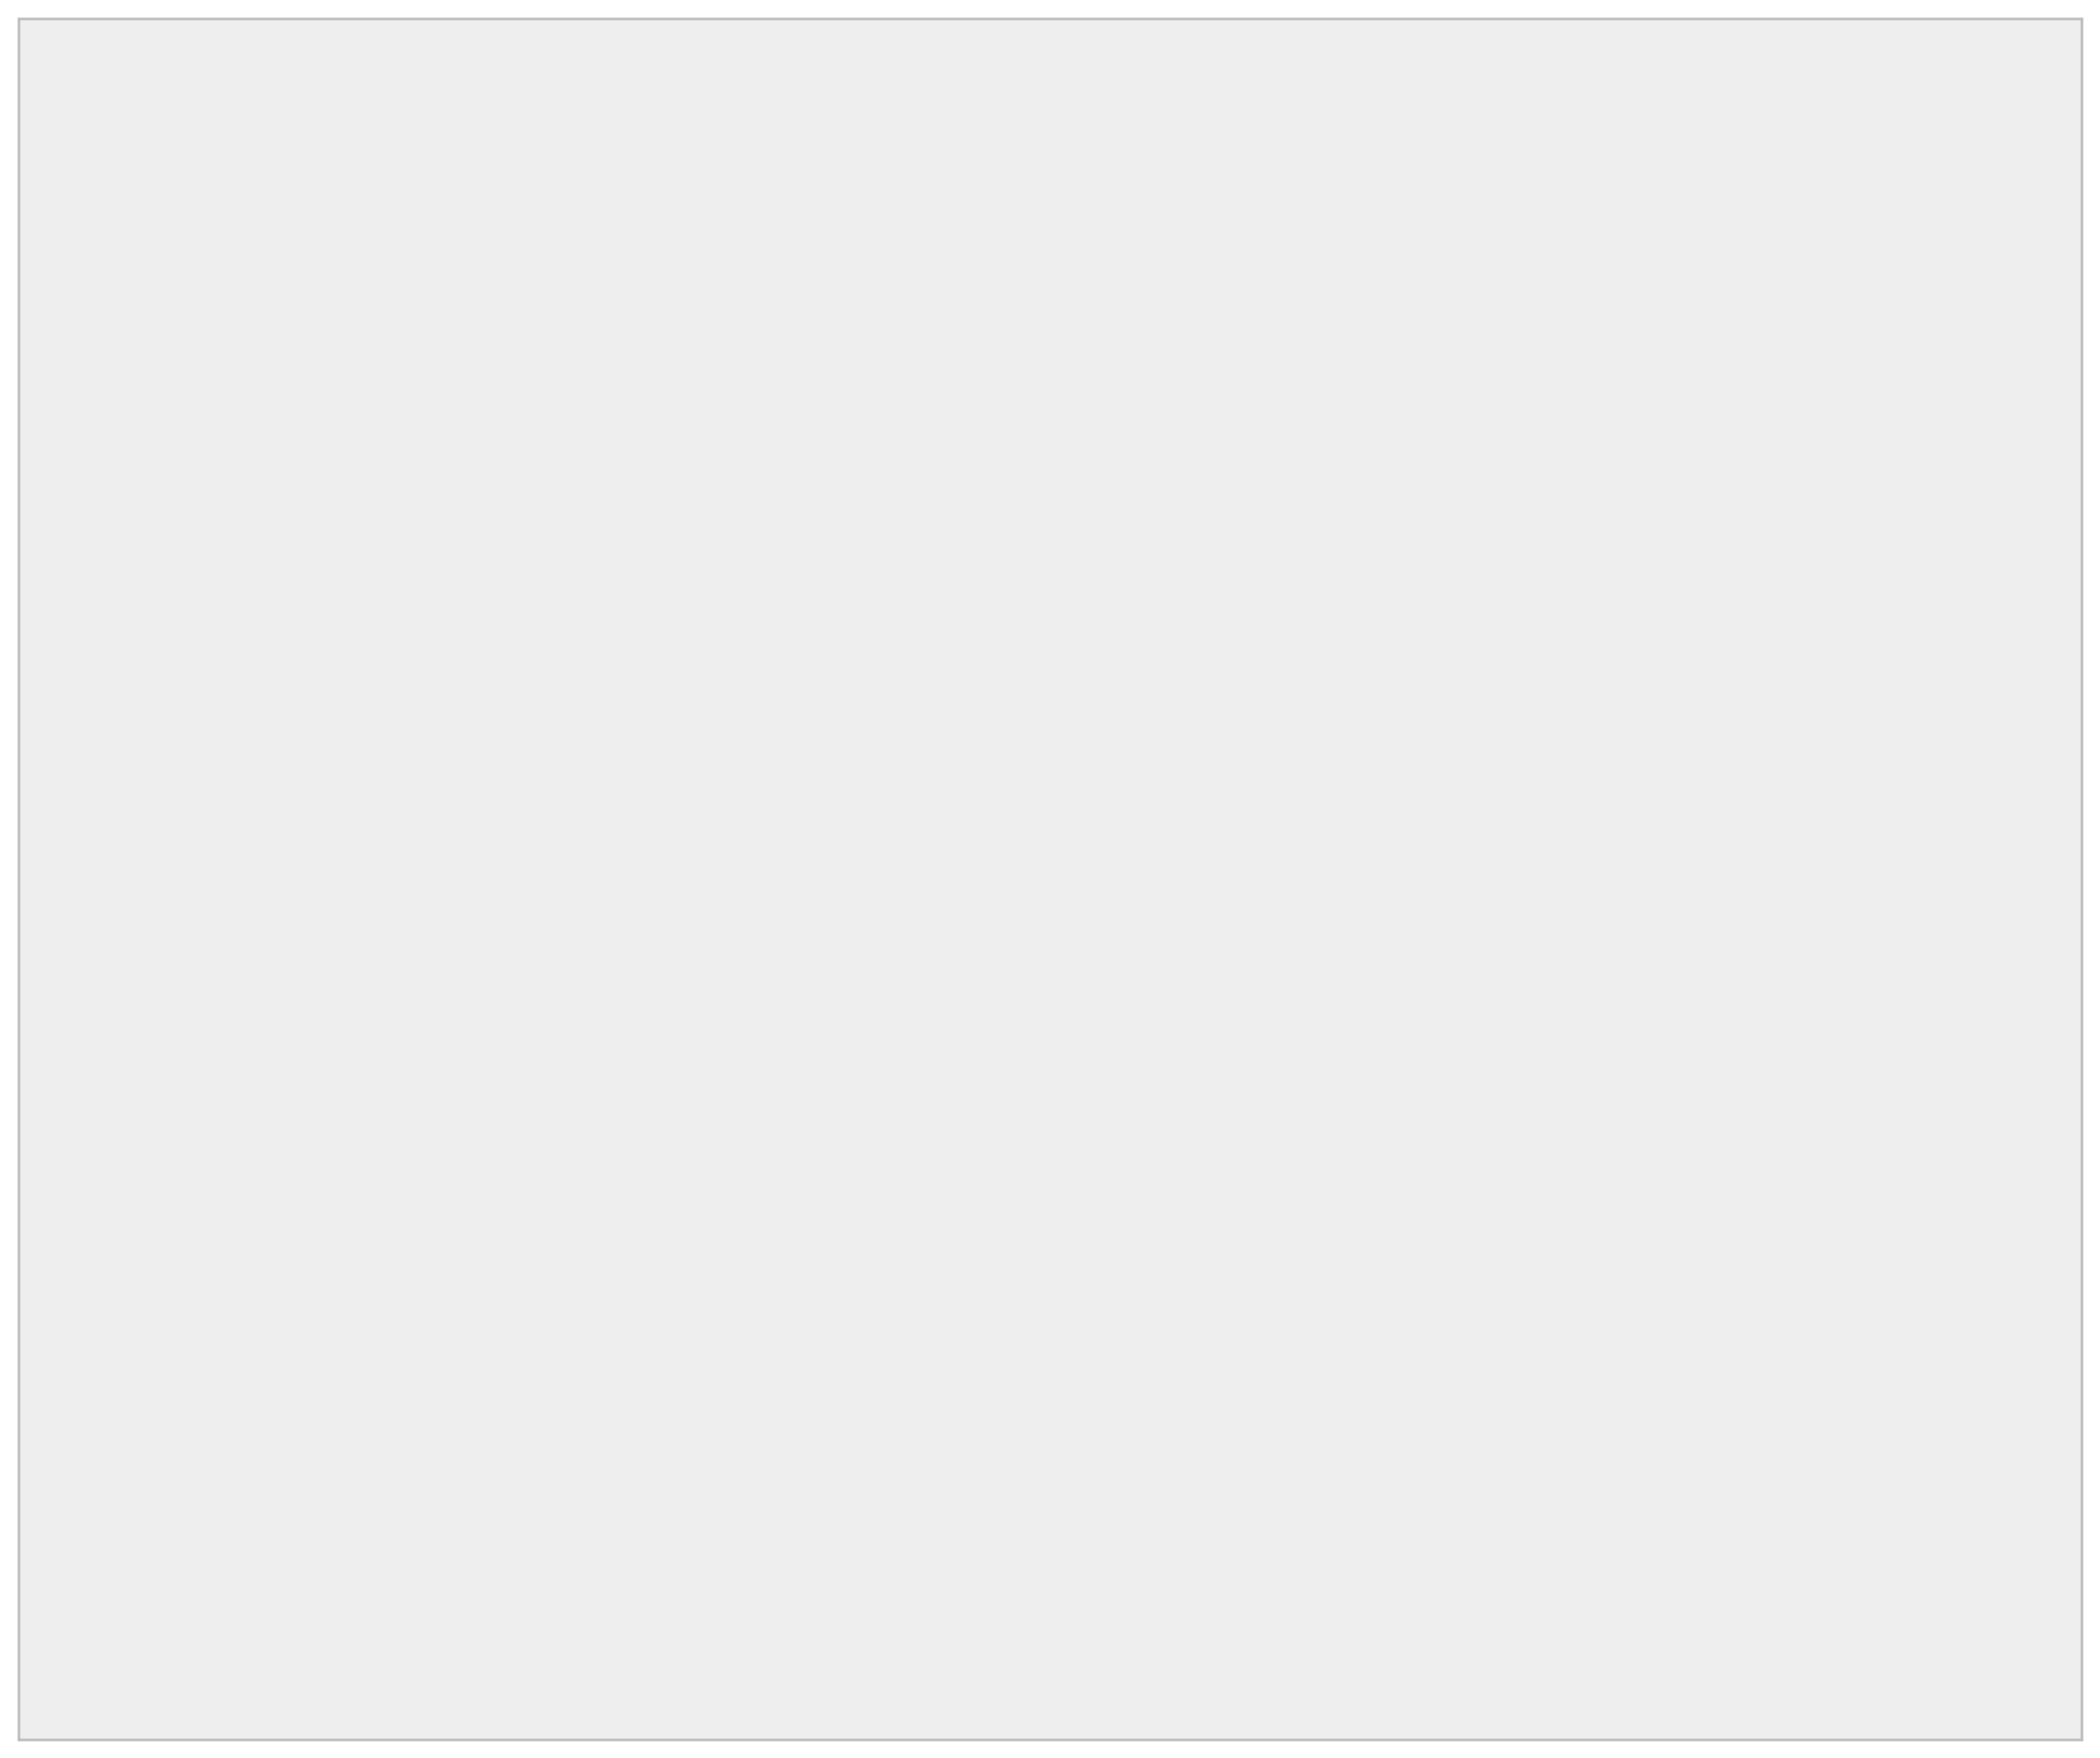

In [5]:
m = Basemap(
    projection='tmerc',
    lon_0 = -2.,
    lat_0 = 49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)
m.readshapefile(
    'data/london_wards',
    'london',
    color='none',
    zorder=2)

In [6]:
# cascade ward polygons together
london_poly = unary_union([Polygon(xy) for xy in m.london])

Mapzen's OSRM instance is being [shut down, and replaced with Valhalla](https://mapzen.com/blog/osrm-sunset), so we're using that instead

In [7]:
def query_travel_time_valhalla(key, start, end, costing, *args):
    """
    Query a Valhalla instance for a route
    Not all options have been implemented here.
    See: https://github.com/valhalla/valhalla-docs/blob/gh-pages/api-reference.md#inputs-of-a-valhalla-route
    """
    allowed = ('pedestrian', 'bicycle', 'bus', 'auto', 'auto_shorter')
    if costing not in allowed:
        raise Exception(
            "Unknown method. Must be one of %s. Christ." % ', '.join(allowed))
    
    # build routing JSON
    initial_route = {
        "locations": [{"lat":start[1] ,"lon": start[0]}, {"lat":end[1] ,"lon":end[0]}],
        "costing": costing,
        "directions_options": {"units": "kilometers"}
    }
    route = initial_route.copy()
    if args:
        route.update(args)
    endpoint = "https://valhalla.mapzen.com/route"
    params = {"json": json.dumps(route), "api_key": key}
    req = requests.get(endpoint, params=params)
    try:
        req.raise_for_status()
    except requests.exceptions.HTTPError:
        return np.nan
    if req.json()['trip']['status'] == 207:
        return np.nan
    return req.json()['trip']['summary']['time']

In [8]:
def project_linestring(ls, inverse=False):
    """ return a linestring projected into map coordinates """
    if not pd.isnull(ls):
        return LineString(zip(*m(*zip(*ls.coords))))
    else:
        return np.nan

## Process XML Station Data

In [9]:
# parse XML into dict
tree = etree.parse("data/bike_stations.xml")
root = tree.getroot()

output = dict()
output['name'] = []
output['lon'] = []
output['lat'] = []

for each in root.xpath('station'):
    output['name'].append(each[1].text)
    output['lon'].append(each[4].text)
    output['lat'].append(each[3].text)

stations = pd.DataFrame(output)
stations[['lon', 'lat']] = stations[['lon', 'lat']].astype(float)

In [10]:
# work out station centroid and WGS84 lon / lat
centroid = zip(*m(*zip(*MultiPoint(stations[['lon', 'lat']].values).convex_hull.centroid.coords)))[0]
centroid

(27087.88141094109, 25298.94044237616)

#### This gives us a problem: the centroid is located in the Thames. Let's shift it a few hundred feet down-river, to Westminster Bridge

In [11]:
centroid = m(-0.12204, 51.50083)
centroid, m(*centroid, inverse=True)

((27054.81221603953, 25108.754540393566),
 (-0.12203999999842599, 51.500829999995766))

In [12]:
# project lon / lat coords
stations['projected_lon'], stations['projected_lat'] = m(*(stations["lon"].values, stations["lat"].values))

In [13]:
# calculate station distance from centroid
stations['centroid_distance'] = stations.apply(lambda x:
    math.sqrt(
        ((abs(centroid[0] - x['projected_lon']) ** 2) + (abs(centroid[1] - x['projected_lat']) ** 2))
    ), axis=1)

## Retrieve Travel Times Between Centroid and Stations

#### By Varying the origin (in `args()`), we can calculate travel times from any point to each station in the network

You can skip the next cell and import travel times from CSV if you wish (don't divide travel by 60, though):  
`stations = pd.read_csv('data/stations_travel_time_valhalla.csv', index_col=0)`

In [46]:
api_key = 'your_valhalla_API_key'

def travel_time(df, start):
    """ return travel times between a given centroid and all stations in the network """
    return query_travel_time_valhalla(api_key, start, (df['lon'], df['lat']), 'bicycle')


stations['travel_time'] = stations.apply(travel_time, args=(m(*centroid, inverse=True),), axis=1)
# travel time in minutes is more useful
stations['travel_time'] /=  60.

/Users/sth/dev/xmltocsv/venv/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/Users/sth/dev/xmltocsv/venv/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/Users/sth/dev/xmltocsv/venv/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 

In [47]:
# replace travel time of < 1 with 1. minutes - not sure about this
# stations.loc[stations['travel_time'] <= 1., 'travel_time'] = 1.
# save our original DataFrame - we're going to drop empty travel time stations
stations_orig = pd.DataFrame(stations)
stations = stations.dropna()

In [24]:
# this station is closest to the centroid
stations.ix[stations['centroid_distance'].idxmin()]

lat                                     51.49824
lon                                   -0.1174959
name                 Archbishop's Park, Waterloo
projected_lon                           27377.72
projected_lat                           24828.92
centroid_distance                       427.2886
travel_time                             2.516667
Name: 611, dtype: object

## Interpolate to Regular Grid  

###### Choose either `griddata` (Matplotlib's mlab version), or `scipy.interpolate.griddata`.  
###### The former runs in around 4.5s, the latter runs in around 51ms, nearly two orders of magnitude faster

In [49]:
# set up a square grid with the same extents as our measured data
numcols, numrows = 1000, 1000
xi = np.linspace(stations['projected_lon'].min(), stations['projected_lon'].max(), numcols)
yi = np.linspace(stations['projected_lat'].min(), stations['projected_lat'].max(), numrows)
# get lon and lat coords of our grid points
xi, yi = np.meshgrid(xi, yi)
# interpolate using Matplotlib (slow-ish)
# x, y, z = stations['projected_lon'].values, stations['projected_lat'].values, stations['travel_time'].values
# zi = griddata(x, y, z, xi, yi)

In [50]:
# interpolate using scipy (fast, but weird lower bound if 'cubic')
zi = gd((stations[['projected_lon', 'projected_lat']]), stations['travel_time'].values, (xi, yi), method='linear')

## Plot

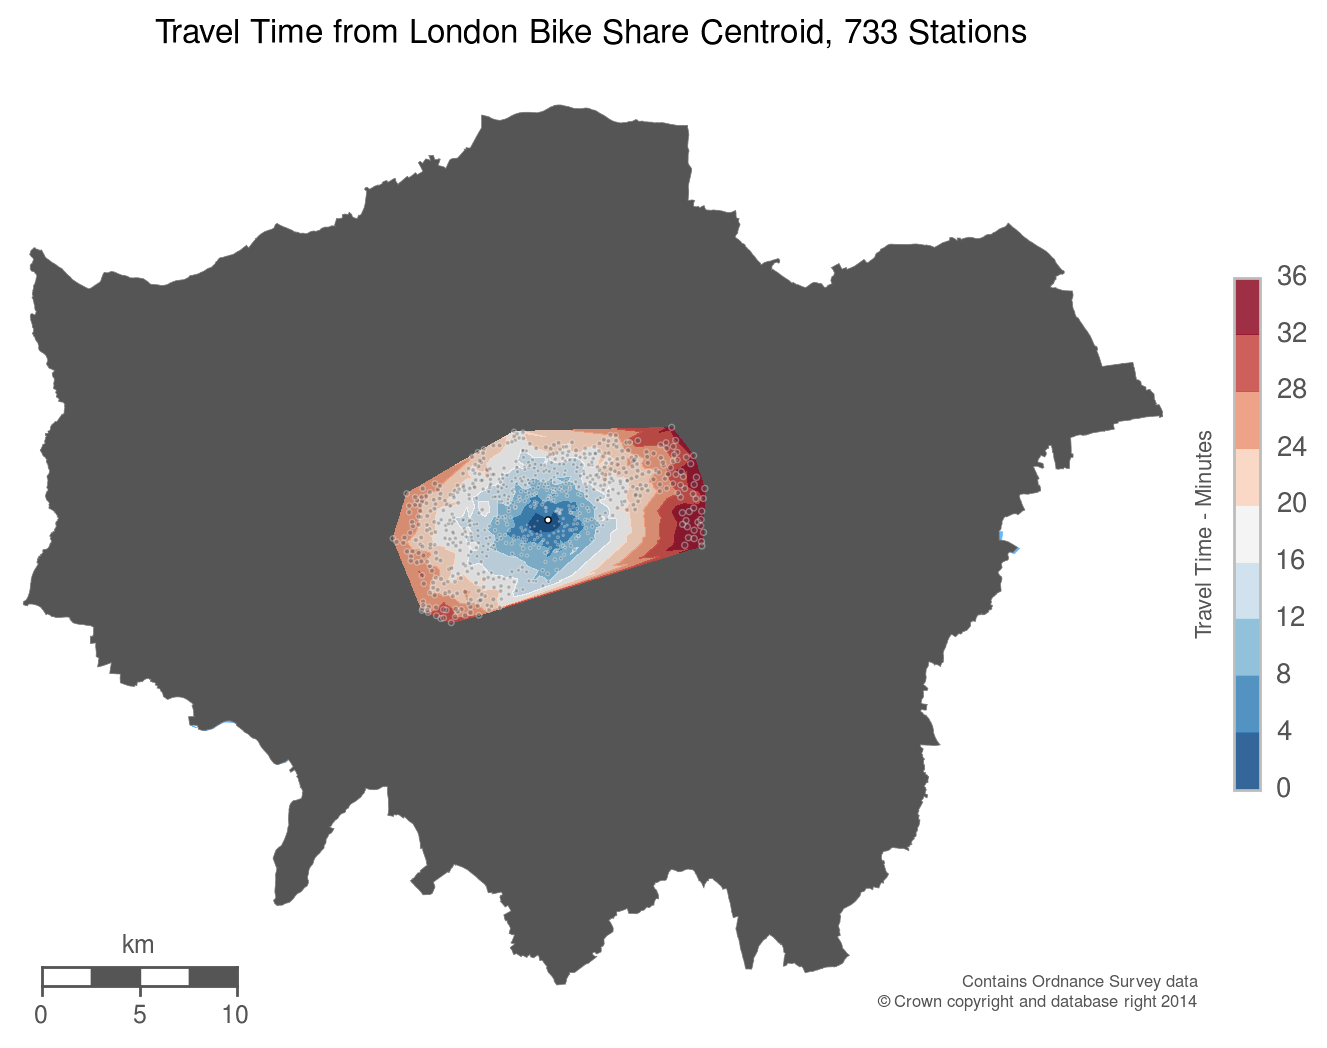

In [51]:
norm = Normalize()

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
m.drawparallels(
    np.arange(ll[0], ur[0], 2.),
    color = 'black', linewidth = 0.5,
    labels=[True, False, False, False], ax=ax)
m.drawmeridians(
    np.arange(ll[1], ur[1], 2.),
    color = 'black', linewidth = 0.5,
    labels=[False, False, False, True], ax=ax)
# plot London outline
lp = PolygonPatch(
    london_poly,
    fc='#555555', ec='#787878', lw=.25, alpha=1., zorder=1)
ax.add_patch(lp)

# contour plots
# con = m.contour(xi, yi, zi, 15, zorder=4, linewidths=.25, linestyles='dashed', colors='k', alpha=0.6, ax=ax)
conf = m.contourf(xi, yi, zi, 10, zorder=4, alpha=0.85, cmap='RdBu_r', ax=ax)

# plot thames
thames = m.readshapefile(
    'data/thames_wgs84',
    'thames',
    color='none',
    zorder=4)
# cascade thames polygons together
thames_poly = unary_union([Polygon(xy) for xy in m.thames])
tp = PatchCollection(
    [PolygonPatch(poly) for poly in thames_poly],
    match_original=False,
    color='#63B8FF', lw=.25, alpha=1., zorder=1)
ax.add_collection(tp)

# scatter plot - vmin/max for colormap compat
# I'm scaling the points by the travel duration
m.scatter(
    stations['projected_lon'],
    stations['projected_lat'],
    color='#545454',
    edgecolor='#ffffff',
    alpha=.35,
    s=5 * norm(stations['travel_time'].values),
    cmap='RdBu',
    ax=ax,
    vmin=zi.min(), vmax=zi.max(), zorder=5)

# add centroid
m.scatter(*centroid,
    s=5., edgecolor='#000000', alpha=1.,
    color='w', zorder=5)

# add colour bar, title, and scale
cbar = plt.colorbar(conf, shrink=.5)
cbar.set_label("Travel Time - Minutes", size=8, labelpad=-40)

# We need to reproduce the OS Data copyright licence
smallprint = ax.text(
    1.03, 0,
    r'\begin{flushright}Contains Ordnance Survey data\\\copyright~Crown copyright and database right 2014\end{flushright}',
    ha='right', va='bottom',
    size=6,
    color='#555555',
    transform=ax.transAxes,
)

plt.title(
    "Travel Time from London Bike Share Centroid, %s Stations" % (
    len(stations),),
    fontsize=12)
m.drawmapscale(
    coords[0] + 0.08, coords[1] + 0.0085,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)

plt.tight_layout()
fig.set_size_inches(7.28, 5.25)
plt.savefig("data/isochrone_centroid.png", format="png", bbox_inches='tight', alpha=True, transparent=True, dpi=300)
plt.show()

Travel time retrieval from MapZen OSRM

## What if we want to show stations reachable from the centroid *for free* (i.e. within 30 mins)?

In [52]:
free = stations[stations['travel_time'] <= 30.]

## Interpolate new DF

In [53]:
# set up a square grid with the same extents as our measured data
numcols, numrows = 1000, 1000
xi = np.linspace(free['projected_lon'].min(), free['projected_lon'].max(), numcols)
yi = np.linspace(free['projected_lat'].min(), free['projected_lat'].max(), numrows)
# get lon and lat coords of our grid points
xi, yi = np.meshgrid(xi, yi)
# interpolate
zi = gd(
    (free[['projected_lon', 'projected_lat']]),
    free['travel_time'].values,
    (xi, yi),
    method='linear')

## Plot Station Subset

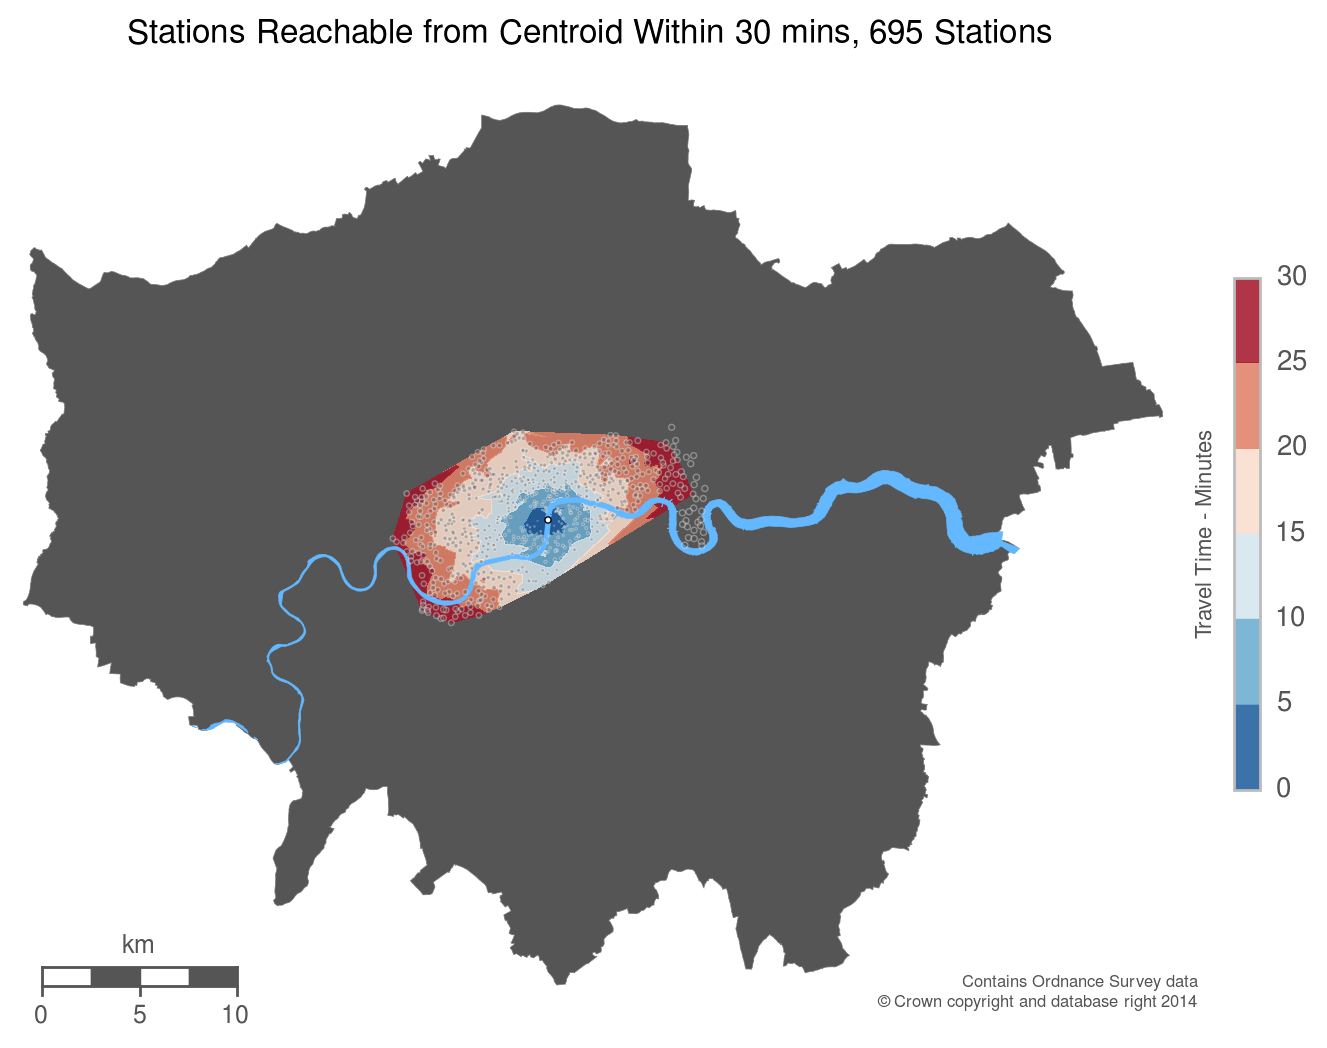

In [54]:
norm = Normalize()

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

m.drawparallels(
    np.arange(ll[0], ur[0], 2.),
    color = 'black', linewidth = 0.5,
    labels=[True, False, False, False], ax=ax)
m.drawmeridians(
    np.arange(ll[1], ur[1], 2.),
    color = 'black', linewidth = 0.5,
    labels=[False, False, False, True], ax=ax)

# plot London outline
lp = PolygonPatch(
    london_poly,
    fc='#555555', ec='#787878', lw=.25, alpha=1., zorder=3)
ax.add_patch(lp)

# contour plots
# con = m.contour(xi, yi, zi, 15, zorder=4, linewidths=.25, linestyles='dashed', colors='k', alpha=0.6, ax=ax)
sconf = m.contourf(xi, yi, zi, 6, zorder=4, alpha=0.85, cmap='RdBu_r', ax=ax)

# plot thames
thames = m.readshapefile(
    'data/thames_wgs84',
    'thames',
    color='none',
    zorder=4)
# cascade thames polygons together
thames_poly = unary_union([Polygon(xy) for xy in m.thames])
tp = PatchCollection(
    [PolygonPatch(poly) for poly in thames_poly],
    match_original=False,
    color='#63B8FF', lw=.25, alpha=1., zorder=5)
ax.add_collection(tp)

# scatter plot - vmin/max for colormap compat
# I'm scaling the points by the travel duration
norm(stations['travel_time'].values)
m.scatter(
    stations['projected_lon'],
    stations['projected_lat'],
    color='#545454',
    edgecolor='#ffffff',
    alpha=.35,
    s=5 * norm(stations['travel_time'].values),
    cmap='RdBu',
    ax=ax,
    vmin=zi.min(), vmax=zi.max(), zorder=5)

# add centroid
m.scatter(*centroid,
    s=5., edgecolor='#000000', alpha=1.,
    color='w', zorder=5)

# add colour bar, title, and scale
cbar = plt.colorbar(sconf, shrink=.5)
cbar.set_label("Travel Time - Minutes", size=8, labelpad=-40)

# We need to reproduce the OS Data copyright licence
smallprint = ax.text(
    1.03, 0,
    r'\begin{flushright}Contains Ordnance Survey data\\\copyright~Crown copyright and database right 2014\end{flushright}',
    ha='right', va='bottom',
    size=6,
    color='#555555',
    transform=ax.transAxes,
)

plt.title(
    "Stations Reachable from Centroid Within 30 mins, %s Stations" % (
    len(free),),
    fontsize=12)
m.drawmapscale(
    coords[0] + 0.08, coords[1] + 0.0085,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)

plt.tight_layout()
fig.set_size_inches(7.28, 5.25)
plt.savefig("data/isochrone_centroid_b.png", format="png", bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## Combining histogram and map

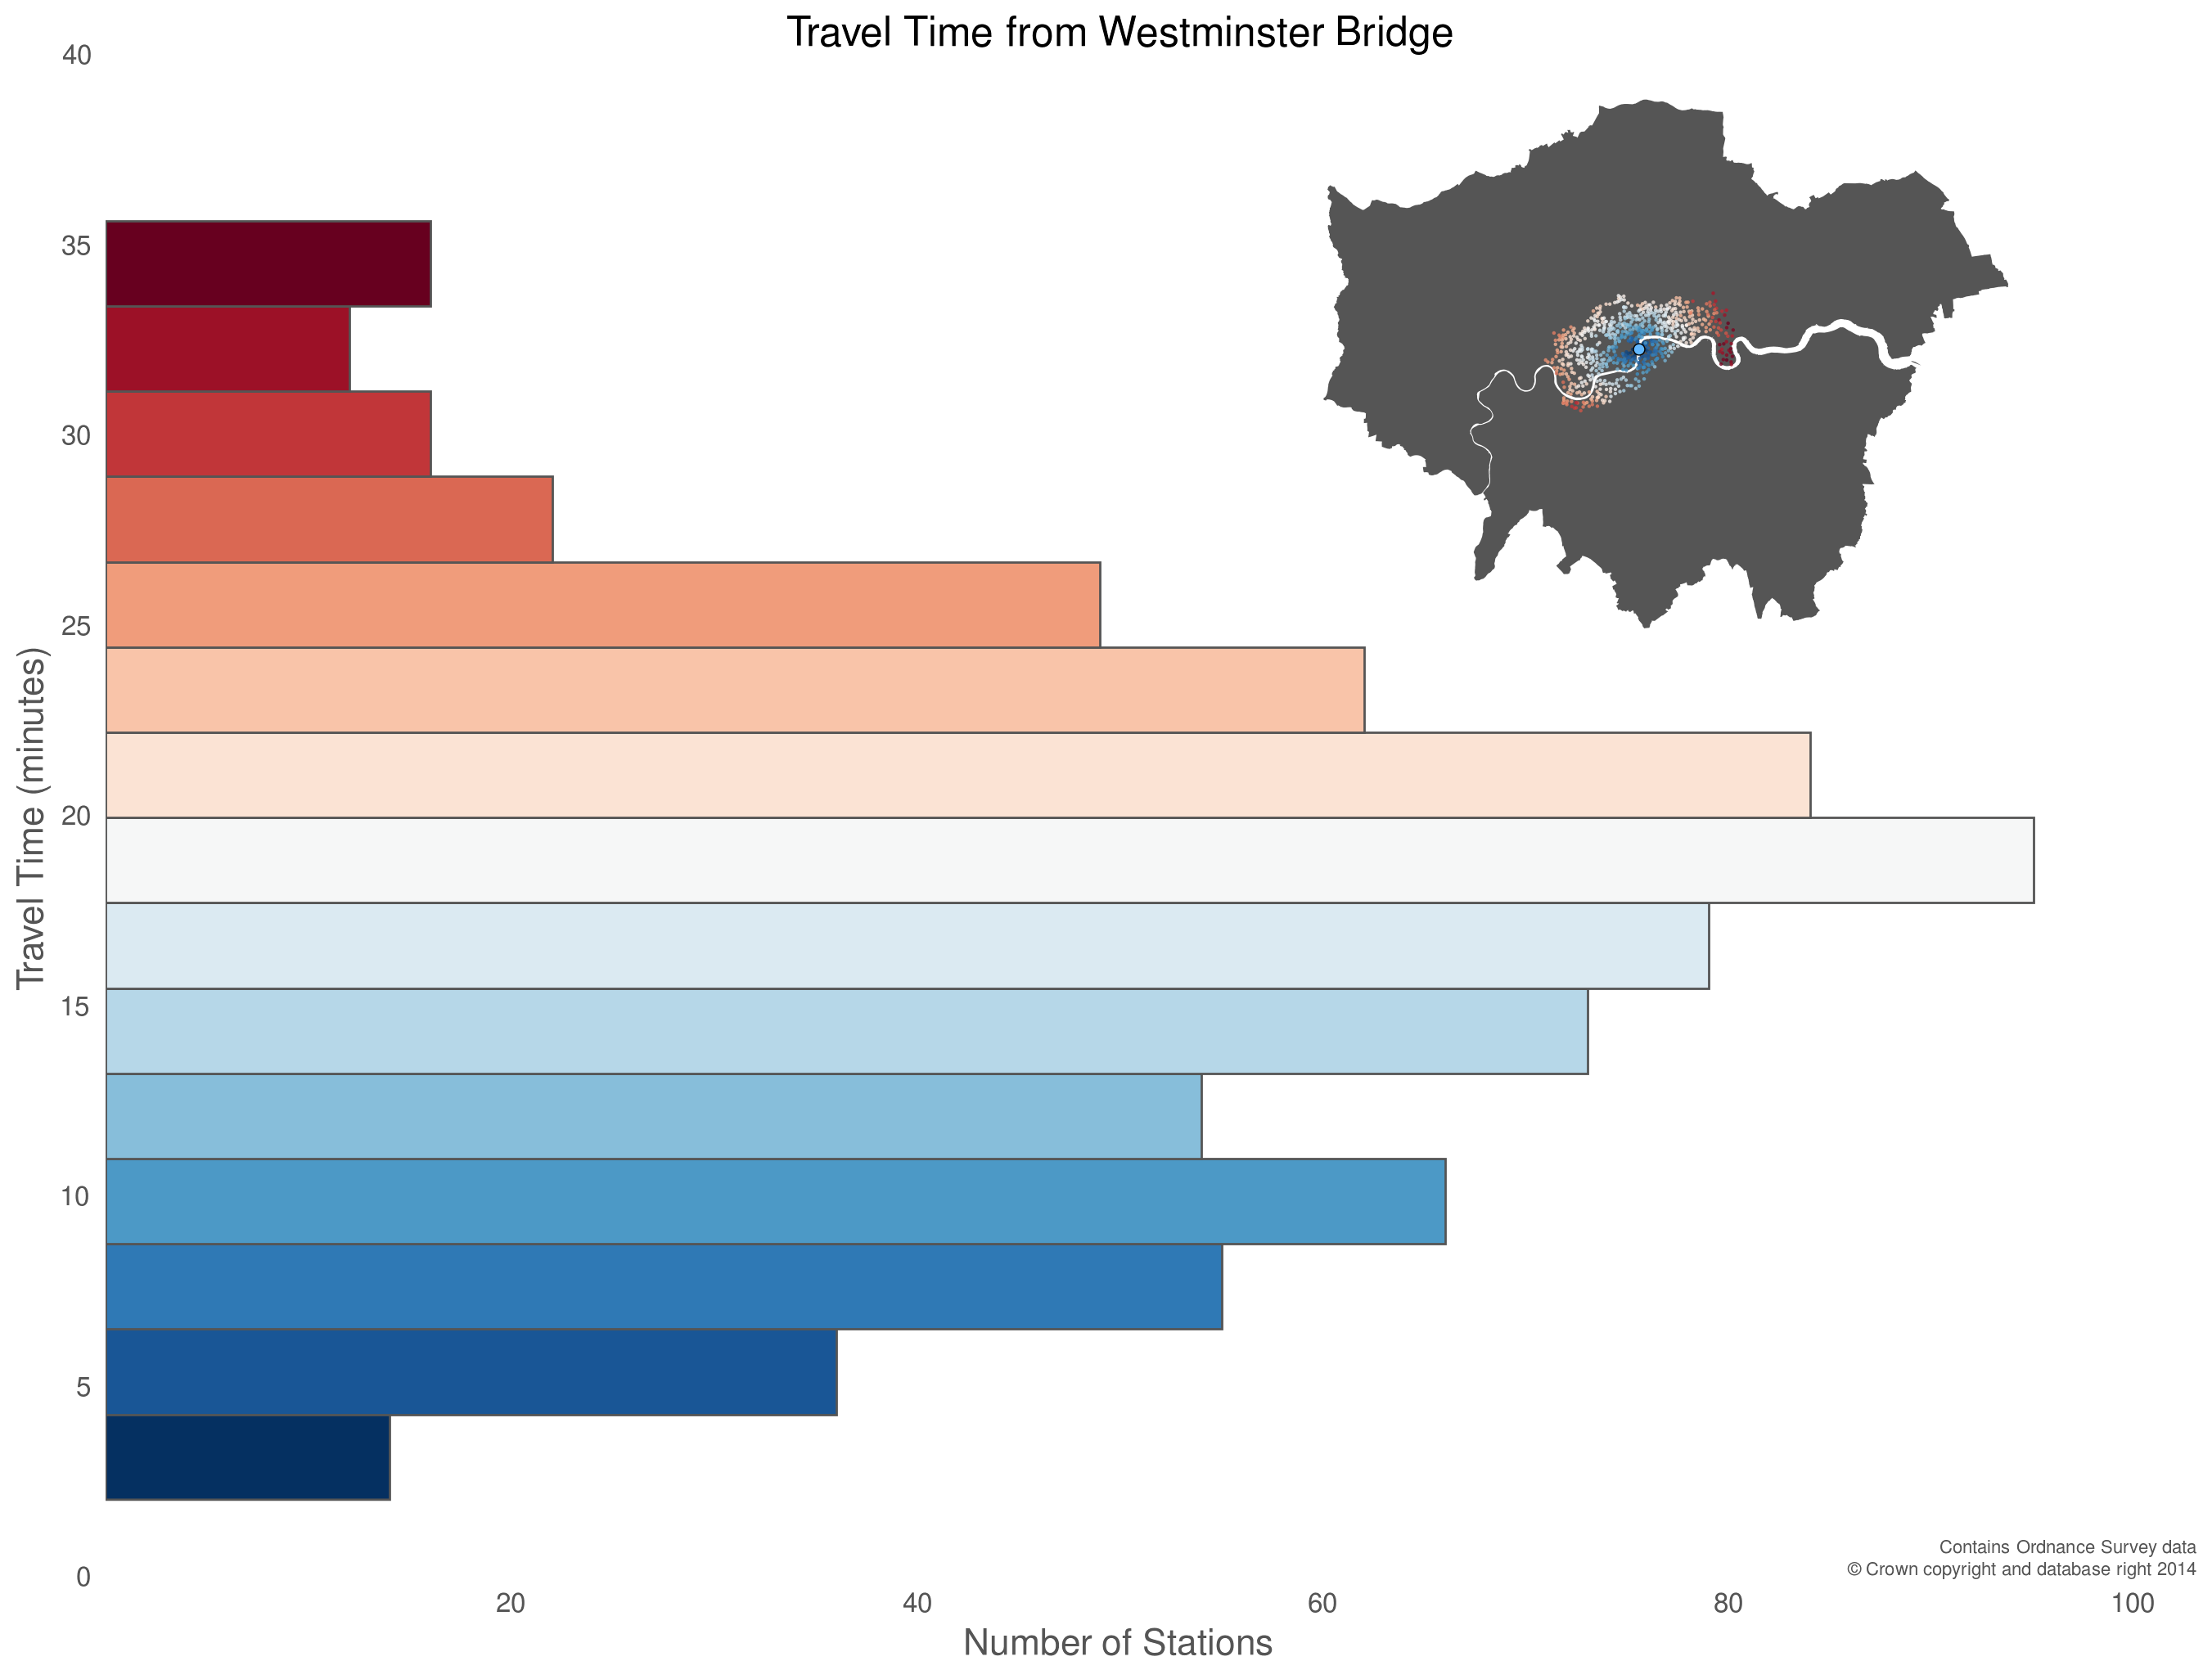

In [55]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# stations['travel_time'].plot(kind='hist', orientation='horizontal', bins=15, color='#555555', ax=ax)
cm = plt.cm.get_cmap('RdBu_r')
n, bins, patches = ax.hist(
    stations['travel_time'],
    bins=15, orientation='horizontal',
    color='#555555',
    ec='#555555',
    lw=1.)

# manually impose colour map
bin_centers = 0.5 * (bins[:-1] + bins[1:])
normed = Normalize()
for c, p in zip(normed(bin_centers), patches):
    plt.setp(p, 'facecolor', cm(c))

# fix ticks and grids
# histogram plotted on weird axes
axh = plt.gca()
axh.grid(b=None)

ax.set_xlabel('Number of Stations', size=16)
ax.set_ylabel('Travel Time (minutes)', size=16)
xticks = ax.xaxis.get_major_ticks()
for tick in xticks:
    tick.label.set_fontsize(12) 
xticks[0].label1.set_visible(False)
yticks = ax.yaxis.get_major_ticks()
for tick in yticks:
    tick.label.set_fontsize(12) 
ax.grid(b=None)

plt.title("Travel Time from Westminster Bridge", size=18)
# We need to reproduce the OS Data copyright licence
smallprint = ax.text(
    1.03, 0,
    r'\begin{flushright}Contains Ordnance Survey data\\\copyright~Crown copyright and database right 2014\end{flushright}',
    ha='right', va='bottom',
    size=8,
    color='#555555',
    transform=ax.transAxes,
)
# map inset
axins = inset_axes(
    ax,
    width="45%", # width = % of parent_bbox
    height=3.5,
    loc=1)
axins.axis[:].toggle(ticklabels=False)
axins.set_axis_off()
m.scatter(
    stations['projected_lon'],
    stations['projected_lat'],
    c=stations['travel_time'],
    color='#FF0080',
    edgecolor='none',
    alpha=.8,
    s=2.5,
    cmap='RdBu_r',
    ax=axins,
    vmin=stations['travel_time'].min(), vmax=stations['travel_time'].max(), zorder=5)

m.scatter(*centroid,
    s=25., edgecolor='#000000', alpha=1.,
    color='#63B8FF', zorder=5, ax=axins)

# this makes the Thames transparent 
lp = PatchCollection(
    [PolygonPatch(poly) for poly in london_poly.difference(Polygon(m.thames[0]).buffer(0))],
    color='#555555', lw=.0001, alpha=1., zorder=3, match_original=False)

axins.add_collection(lp)
# fig.set_size_inches(7.28, 5.25)
plt.savefig("data/inset.png", format="png", bbox_inches='tight', transparent=True, alpha=True, dpi=300)
plt.show()